# Check Trained Model (offline test, Figure 2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import argparse
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import netCDF4 as nc
import os, sys

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import torch.distributed as dist
import copy
from utils import *
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from matplotlib import colors

In [2]:
class UltimateRNN(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, sample_size, A=None, B=None, C=None, lr=1e-3, inputs_val=None, targets_val=None):
        super(UltimateRNN, self).__init__()
        if A is None:
            A = np.eye(hidden_size, hidden_size)
        if B is None:
            B = np.eye(hidden_size, input_size)
        if C is None:
            C = np.eye(output_size, hidden_size)
        self.sample_size = sample_size
        self.hidden_size = hidden_size
        
        self.relu = nn.ReLU()
        self.input_layer_linear = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        self.input_layer_1 = nn.Linear(input_size+hidden_size, 3*(input_size+hidden_size))
        self.input_layer_2 = nn.Linear(3*(input_size+hidden_size), 3*(input_size+hidden_size))
        self.input_layer_3 = nn.Linear(3*(input_size+hidden_size), hidden_size)
        
        self.output_layer = nn.Linear(hidden_size, output_size, bias=False)

        # Initialize weight matrices and bias vectors for the RNN layer
        self.input_layer_linear.weight.data = torch.from_numpy(np.concatenate((copy.deepcopy(A), copy.deepcopy(B)), axis=1))
        nn.init.normal_(self.input_layer_1.weight, mean=0, std=0.001*torch.std(self.input_layer_linear.weight.data))
        nn.init.normal_(self.input_layer_2.weight, mean=0, std=0.001*torch.std(self.input_layer_linear.weight.data))
        nn.init.normal_(self.input_layer_3.weight, mean=0, std=0.001*torch.std(self.input_layer_linear.weight.data))
        nn.init.zeros_(self.input_layer_1.bias)
        nn.init.zeros_(self.input_layer_2.bias)
        nn.init.zeros_(self.input_layer_3.bias)
        
        # Initialize output layers
        self.output_layer.weight.data = torch.from_numpy(copy.deepcopy(C))
        
        # initialize hidden state
        self.h0 = nn.Parameter(torch.zeros(sample_size, hidden_size))
        
        # Initialize lists to store loss values
        self.train_losses = []
        self.val_preces = []
        self.val_biases = []
        self.pred = None
        
        self.register_buffer("inputs_val", inputs_val)
        self.register_buffer("targets_val", targets_val)
        
        self.lr = lr

    def forward(self, x, index):
        h = [self.h0[index, :]]
        #print(h[-1].shape, x.shape, index)
        for istep in range(x.shape[0]-1):
            rnn_input = torch.cat((h[-1], x[istep, :, :]), axis=1)
            h.append(
                self.input_layer_linear(rnn_input) + self.input_layer_3(self.relu(self.input_layer_2(self.relu(self.input_layer_1(rnn_input)))))
            )
        rnnh = torch.stack(h, axis=0)
        out = self.output_layer(rnnh)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y, idx = batch
        x = x.permute(1, 0, 2)
        y = y.permute(1, 0, 2)
        y_hat = self(x, idx)
        loss = self.loss_function(y_hat, y)
        self.log('train_loss', np.sqrt(loss.item()), sync_dist=True)
        self.train_losses.append(np.sqrt(loss.item()))
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        print("Calling validation_step()")
        
        if self.inputs_val is not None:
            pred = self(self.inputs_val, np.arange(self.inputs_val.shape[1])*(self.sample_size//self.inputs_val.shape[1]))
            diff = pred - self.targets_val
            bias = torch.mean(diff, axis=0) / torch.std(self.targets_val, axis=0)
            prec = torch.std(diff, axis=0) / torch.std(self.targets_val, axis=0)
            self.val_preces.append(prec)
            self.val_biases.append(bias)
    
    def test_step(self, val_batch, batch_idx):
        print("Calling test_step()")
        
        if self.inputs_val is not None:
            pred = self(self.inputs_val, np.arange(self.inputs_val.shape[1])*(self.sample_size//self.inputs_val.shape[1]))
            self.pred = pred
    
    def loss_function(self, output, target):
        var_target = torch.var(target)
        scaled_loss = torch.mean((output - target)**2) / var_target
        return scaled_loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [3]:
hidden_size = 64
loadmodel = None
loadmodel = '/n/netscratch/kuang_lab/Lab/qiyusong/SAM_RNN/logs/paper_final_rand_4_to_50_seqlen_192_skip_48_noisywave1.0_6to20_damp2_seqlen_192_skip_24_all_param_2e-06_256/version_0/checkpoints/epoch=4879-val_loss=0.101.ckpt'
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
torch.set_float32_matmul_precision('high')

### Random forcing experiments

inputs_valid.shape = torch.Size([96000, 18, 40])
(64, 64)
(64, 40)
(41, 64)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


odict_keys(['h0', 'inputs_val_rand', 'targets_val_rand', 'inputs_val_wave', 'targets_val_wave', 'input_layer_linear.weight', 'input_layer_1.weight', 'input_layer_1.bias', 'input_layer_2.weight', 'input_layer_2.bias', 'input_layer_3.weight', 'input_layer_3.bias', 'output_layer.weight'])
odict_keys(['h0', 'inputs_val', 'targets_val', 'input_layer_linear.weight', 'input_layer_1.weight', 'input_layer_1.bias', 'input_layer_2.weight', 'input_layer_2.bias', 'input_layer_3.weight', 'input_layer_3.bias', 'output_layer.weight'])
input_layer_linear.weight
input_layer_1.weight
input_layer_1.bias
input_layer_2.weight
input_layer_2.bias
input_layer_3.weight
input_layer_3.bias
output_layer.weight
Calling test_step()
tensor([0.0842, 0.0815, 0.0687, 0.0652, 0.0656, 0.0628, 0.0678, 0.0650, 0.0760,
        0.0721, 0.0849, 0.0795, 0.0947, 0.0885, 0.0988, 0.0935, 0.1078, 0.1020])


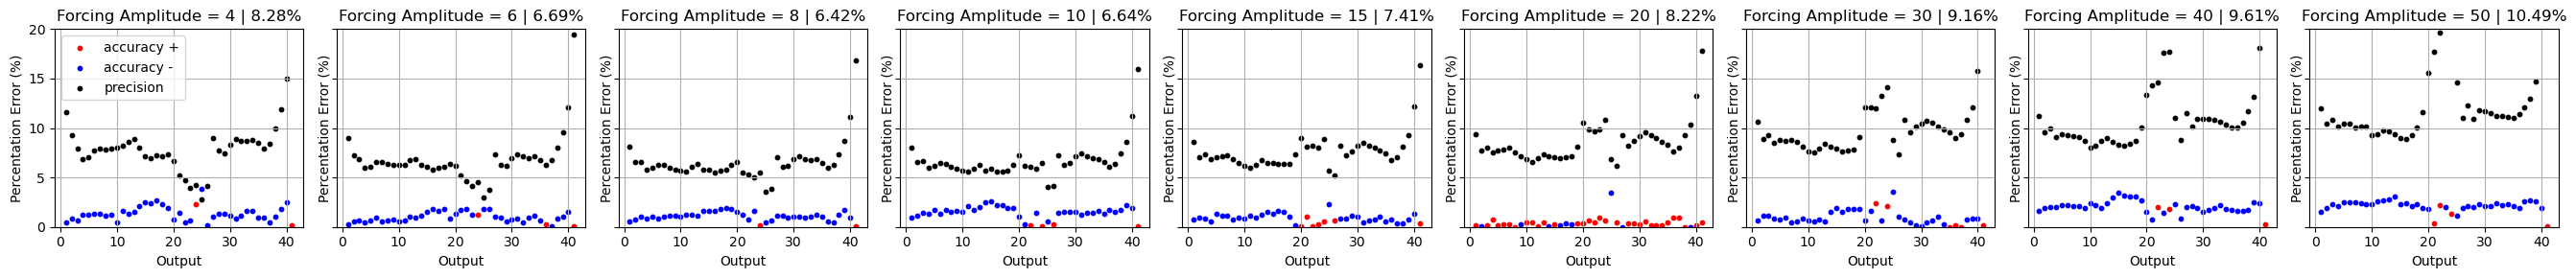

In [5]:
SAMdata = []
h0_inds = []
count = 0
for msinefx in [4, 6, 8, 10, 15, 20, 30, 40, 50]:
    for iexp in [0, 1]:
        testdata = np.load(f'/n/kuangdss01/users/qiyusong/SAM_RNN/data/msinefx{msinefx}_{iexp}_256_addp.npz')
        SAMdata.append(testdata)
        h0_inds.append(count * 1597)
        count += 1

sample_size=len(SAMdata)
train_dataset = TensorDataset(torch.tensor(np.arange(sample_size)))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=False)

inputs_valid = []
targets_valid = []
for data in SAMdata:
    inputs_valid_exp =  torch.from_numpy(data['input_weighted']).unsqueeze(1)
    targets_valid_exp = torch.from_numpy(data['target_weighted']).unsqueeze(1)
    inputs_valid.append(inputs_valid_exp)
    targets_valid.append(targets_valid_exp)
inputs_valid = torch.cat(inputs_valid, axis=1)
targets_valid = torch.cat(targets_valid, axis=1)
print(f"inputs_valid.shape = {inputs_valid.shape}")
valid_dataset = TensorDataset(inputs_valid.permute(1, 0, 2), targets_valid.permute(1, 0, 2))
valid_loader = DataLoader(valid_dataset, batch_size=len(SAMdata), shuffle=False, num_workers=1, pin_memory=False)

# train
A, B, C = read_params_from_ssm(hidden_size, input_size=40, output_size=41, name_fix="addp_4x")
model = UltimateRNN(40, hidden_size, 41, sample_size, A, B, C, lr=0., inputs_val=inputs_valid, targets_val=targets_valid)
if loadmodel is not None:
    checkpoint = torch.load(loadmodel, map_location=torch.device('cpu'))
    print(checkpoint["state_dict"].keys())
    print(model.state_dict().keys())

    model_state_dict = model.state_dict()
    for name, param in model.named_parameters():
        if name=='h0': continue
        if name in checkpoint["state_dict"].keys():
            print(name)
            model_state_dict[name] = checkpoint["state_dict"][name]
    model.load_state_dict(model_state_dict)


for param in model.parameters():
    param.requires_grad = False
trainer = pl.Trainer(accelerator="cpu", num_nodes=1, max_epochs=0, log_every_n_steps=1, check_val_every_n_epoch=1, enable_progress_bar=False)

h0 = checkpoint["state_dict"]['h0'][h0_inds, :]
model.h0.data = h0
trainer.test(model=model, dataloaders=valid_loader)

pred = model.pred.cpu()
diff = pred - targets_valid[:, :, :]
bias = torch.mean(diff[:, :, :], axis=0) / torch.std(targets_valid[:, :, :], axis=0)
prec = torch.std(diff[:, :, :], axis=0) / torch.std(targets_valid[:, :, :], axis=0)
length = inputs_valid.shape[0]

pred.shape

print(torch.sqrt(torch.mean(diff[:, :, :]**2, axis=(0, 2))) / torch.std(targets_valid[:, :, :], axis=(0, 2)))
rmse_rand = torch.sqrt(torch.mean(diff**2, axis=0)) / torch.std(targets_valid[:, :, :], axis=0)
bias_rand = torch.mean(diff[:, :, :], axis=0) / torch.std(targets_valid[:, :, :], axis=0)
# group by amplitude
bias = (bias[::2, :] + bias[1::2, :]) / 2.
prec = (prec[::2, :] + prec[1::2, :]) / 2.

accuracy_p = copy.deepcopy(bias.numpy())
accuracy_p[accuracy_p<0] = np.nan
accuracy_n = copy.deepcopy(bias.numpy())
accuracy_n[accuracy_n>0] = np.nan
accuracy_n *= -1.
precision = copy.deepcopy(prec.numpy())
total = torch.mean(diff[:, :, :]**2, axis=(0, 2)) / torch.var(targets_valid[:, :, :], axis=(0, 2))
total = np.sqrt(total.numpy())
# group by amplitude
total = (total[::2] + total[1::2]) / 2.

# 4-50x, addp
fig, ax = plt.subplots(1, len(SAMdata)//2, figsize=(3*len(SAMdata)//2, 3), sharex=True, sharey=True)
iexp = 0
amp_list = [4, 6, 8, 10, 15, 20, 30, 40, 50]
for icase in range(len(amp_list)):
    ax[icase].scatter(np.arange(1, 42), accuracy_p[icase, :]*100, s=10, c='r', label='accuracy +')
    ax[icase].scatter(np.arange(1, 42), accuracy_n[icase, :]*100, s=10, c='b', label='accuracy -')
    ax[icase].scatter(np.arange(1, 42), precision[icase, :] *100, s=10, c='k', label='precision')
    ax[icase].grid()
    ax[icase].set_xlabel('Output')
    ax[icase].set_ylabel('Percentation Error (%)')
    ax[icase].set_title(f'Forcing Amplitude = {amp_list[icase]} | {round(total[icase]*100, 2)}%')
    ax[icase].set_ylabel
    if icase==0: ax[0].legend(loc='upper left')
ax[0].set_ylim(0, 20)
fig.tight_layout()
plt.show()

### Coupled-wave forcing experiments

inputs_valid.shape = torch.Size([14400, 30, 40])
(64, 64)
(64, 40)
(41, 64)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


odict_keys(['h0', 'inputs_val_rand', 'targets_val_rand', 'inputs_val_wave', 'targets_val_wave', 'input_layer_linear.weight', 'input_layer_1.weight', 'input_layer_1.bias', 'input_layer_2.weight', 'input_layer_2.bias', 'input_layer_3.weight', 'input_layer_3.bias', 'output_layer.weight'])
odict_keys(['h0', 'inputs_val', 'targets_val', 'input_layer_linear.weight', 'input_layer_1.weight', 'input_layer_1.bias', 'input_layer_2.weight', 'input_layer_2.bias', 'input_layer_3.weight', 'input_layer_3.bias', 'output_layer.weight'])
input_layer_linear.weight
input_layer_1.weight
input_layer_1.bias
input_layer_2.weight
input_layer_2.bias
input_layer_3.weight
input_layer_3.bias
output_layer.weight
Calling test_step()
tensor([0.0748, 0.0754, 0.0699, 0.0682, 0.0699, 0.0676, 0.0653, 0.0652, 0.0658,
        0.0676, 0.0720, 0.0715, 0.0710, 0.0720, 0.0703, 0.0770, 0.0709, 0.0749,
        0.0890, 0.0934, 0.0837, 0.0857, 0.0793, 0.0867, 0.0970, 0.1170, 0.0884,
        0.0934, 0.1057, 0.0935])


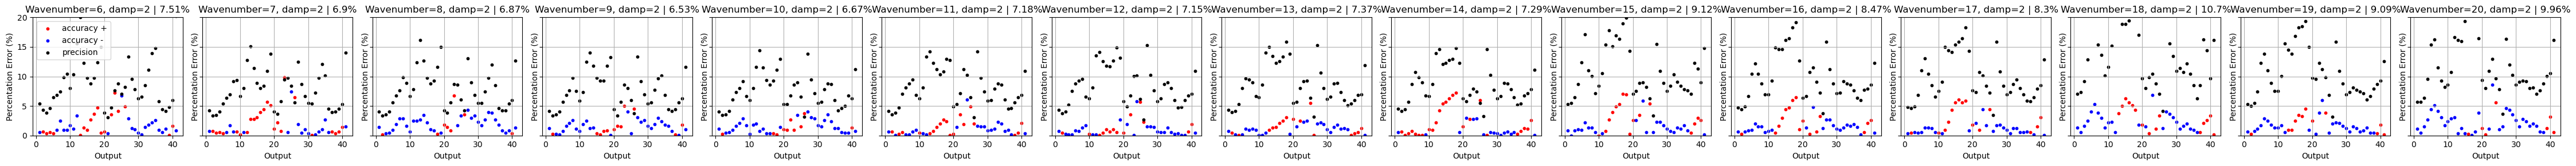

In [6]:
SAMdata = []
h0_inds = []
count = 0

for wn in range(6, 21):
    for damp in [2]:
        testdata = np.load(f'/n/kuangdss01/users/qiyusong/SAM_RNN/data/wn{wn}_damp{damp}day_noadvectbg_noiselevel_1.0_1_addp.npz')
        SAMdata.append(testdata)
        h0_inds.append(18*1597 + count * 474)
        count += 1
        
        testdata = np.load(f'/n/kuangdss01/users/qiyusong/SAM_RNN/data/wn{wn}_damp{damp}day_noadvectbg_noiselevel_1.0_2_addp.npz')
        SAMdata.append(testdata)
        h0_inds.append(18*1597 + count * 474)
        count += 1

sample_size=len(SAMdata)
train_dataset = TensorDataset(torch.tensor(np.arange(sample_size)))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=False)

inputs_valid = []
targets_valid = []
for data in SAMdata:
    inputs_valid_exp =  torch.from_numpy(data['input_weighted']).unsqueeze(1)
    targets_valid_exp = torch.from_numpy(data['target_weighted']).unsqueeze(1)
    inputs_valid.append(inputs_valid_exp)
    targets_valid.append(targets_valid_exp)
inputs_valid = torch.cat(inputs_valid, axis=1)
targets_valid = torch.cat(targets_valid, axis=1)
print(f"inputs_valid.shape = {inputs_valid.shape}")
valid_dataset = TensorDataset(inputs_valid.permute(1, 0, 2), targets_valid.permute(1, 0, 2))
valid_loader = DataLoader(valid_dataset, batch_size=len(SAMdata), shuffle=False, num_workers=1, pin_memory=False)

# train
A, B, C = read_params_from_ssm(hidden_size, input_size=40, output_size=41, name_fix="addp_4x")
model = UltimateRNN(40, hidden_size, 41, sample_size, A, B, C, lr=0., inputs_val=inputs_valid, targets_val=targets_valid)
if loadmodel is not None:
    checkpoint = torch.load(loadmodel, map_location=torch.device('cpu'))
    print(checkpoint["state_dict"].keys())
    print(model.state_dict().keys())

    model_state_dict = model.state_dict()
    for name, param in model.named_parameters():
        if name=='h0': continue
        if name in checkpoint["state_dict"].keys():
            print(name)
            model_state_dict[name] = checkpoint["state_dict"][name]
    model.load_state_dict(model_state_dict)


for param in model.parameters():
    param.requires_grad = False
trainer = pl.Trainer(accelerator="cpu", num_nodes=1, max_epochs=0, log_every_n_steps=1, check_val_every_n_epoch=1, enable_progress_bar=False)

#h0 = torch.stack((checkpoint["state_dict"]['h0'][1597*16, :], checkpoint["state_dict"]['h0'][1597*17, :]), axis=0)
h0 = checkpoint["state_dict"]['h0'][h0_inds, :]

#model.h0.data *= 0.

trainer.test(model=model, dataloaders=valid_loader)

pred = model.pred.cpu()
diff = pred - targets_valid[:, :, :]
bias = torch.mean(diff[:, :, :], axis=0) / torch.std(targets_valid[:, :, :], axis=0)
prec = torch.std(diff[:, :, :], axis=0) / torch.std(targets_valid[:, :, :], axis=0)
length = inputs_valid.shape[0]

pred.shape

print(torch.sqrt(torch.mean(diff[:, :, :]**2, axis=(0, 2))) / torch.std(targets_valid[:, :, :], axis=(0, 2)))
rmse_wave = torch.sqrt(torch.mean(diff**2, axis=0)) / torch.std(targets_valid[:, :, :], axis=0)
bias_wave = torch.mean(diff[:, :, :], axis=0) / torch.std(targets_valid[:, :, :], axis=0)

# group by wavenumber
bias = (bias[::2, :] + bias[1::2, :]) / 2.
prec = (prec[::2, :] + prec[1::2, :]) / 2.

accuracy_p = copy.deepcopy(bias.numpy())
accuracy_p[accuracy_p<0] = np.nan
accuracy_n = copy.deepcopy(bias.numpy())
accuracy_n[accuracy_n>0] = np.nan
accuracy_n *= -1.
precision = copy.deepcopy(prec.numpy())
total = torch.mean(diff[:, :, :]**2, axis=(0, 2)) / torch.var(targets_valid[:, :, :], axis=(0, 2))
total = np.sqrt(total.numpy())
# group by wavenumber
total = (total[::2] + total[1::2]) / 2.

# wn6-20, damp2, addp
fig, ax = plt.subplots(1, len(SAMdata)//2, figsize=(3*len(SAMdata)//2, 3), sharex=True, sharey=True)
iexp = 0
wn_list = list(np.arange(6, 21))
for icase in range(len(wn_list)):
    ax[icase].scatter(np.arange(1, 42), accuracy_p[icase, :]*100, s=10, c='r', label='accuracy +')
    ax[icase].scatter(np.arange(1, 42), accuracy_n[icase, :]*100, s=10, c='b', label='accuracy -')
    ax[icase].scatter(np.arange(1, 42), precision[icase, :] *100, s=10, c='k', label='precision')
    ax[icase].grid()
    ax[icase].set_xlabel('Output')
    ax[icase].set_ylabel('Percentation Error (%)')
    ax[icase].set_title(f'Wavenumber={wn_list[icase]}, damp=2 | {round(total[icase]*100, 2)}%')
    ax[icase].set_ylabel
    if icase==0: ax[0].legend(loc='upper left')
ax[0].set_ylim(0, 20)
fig.tight_layout()
plt.show()

### Percentage RMSE

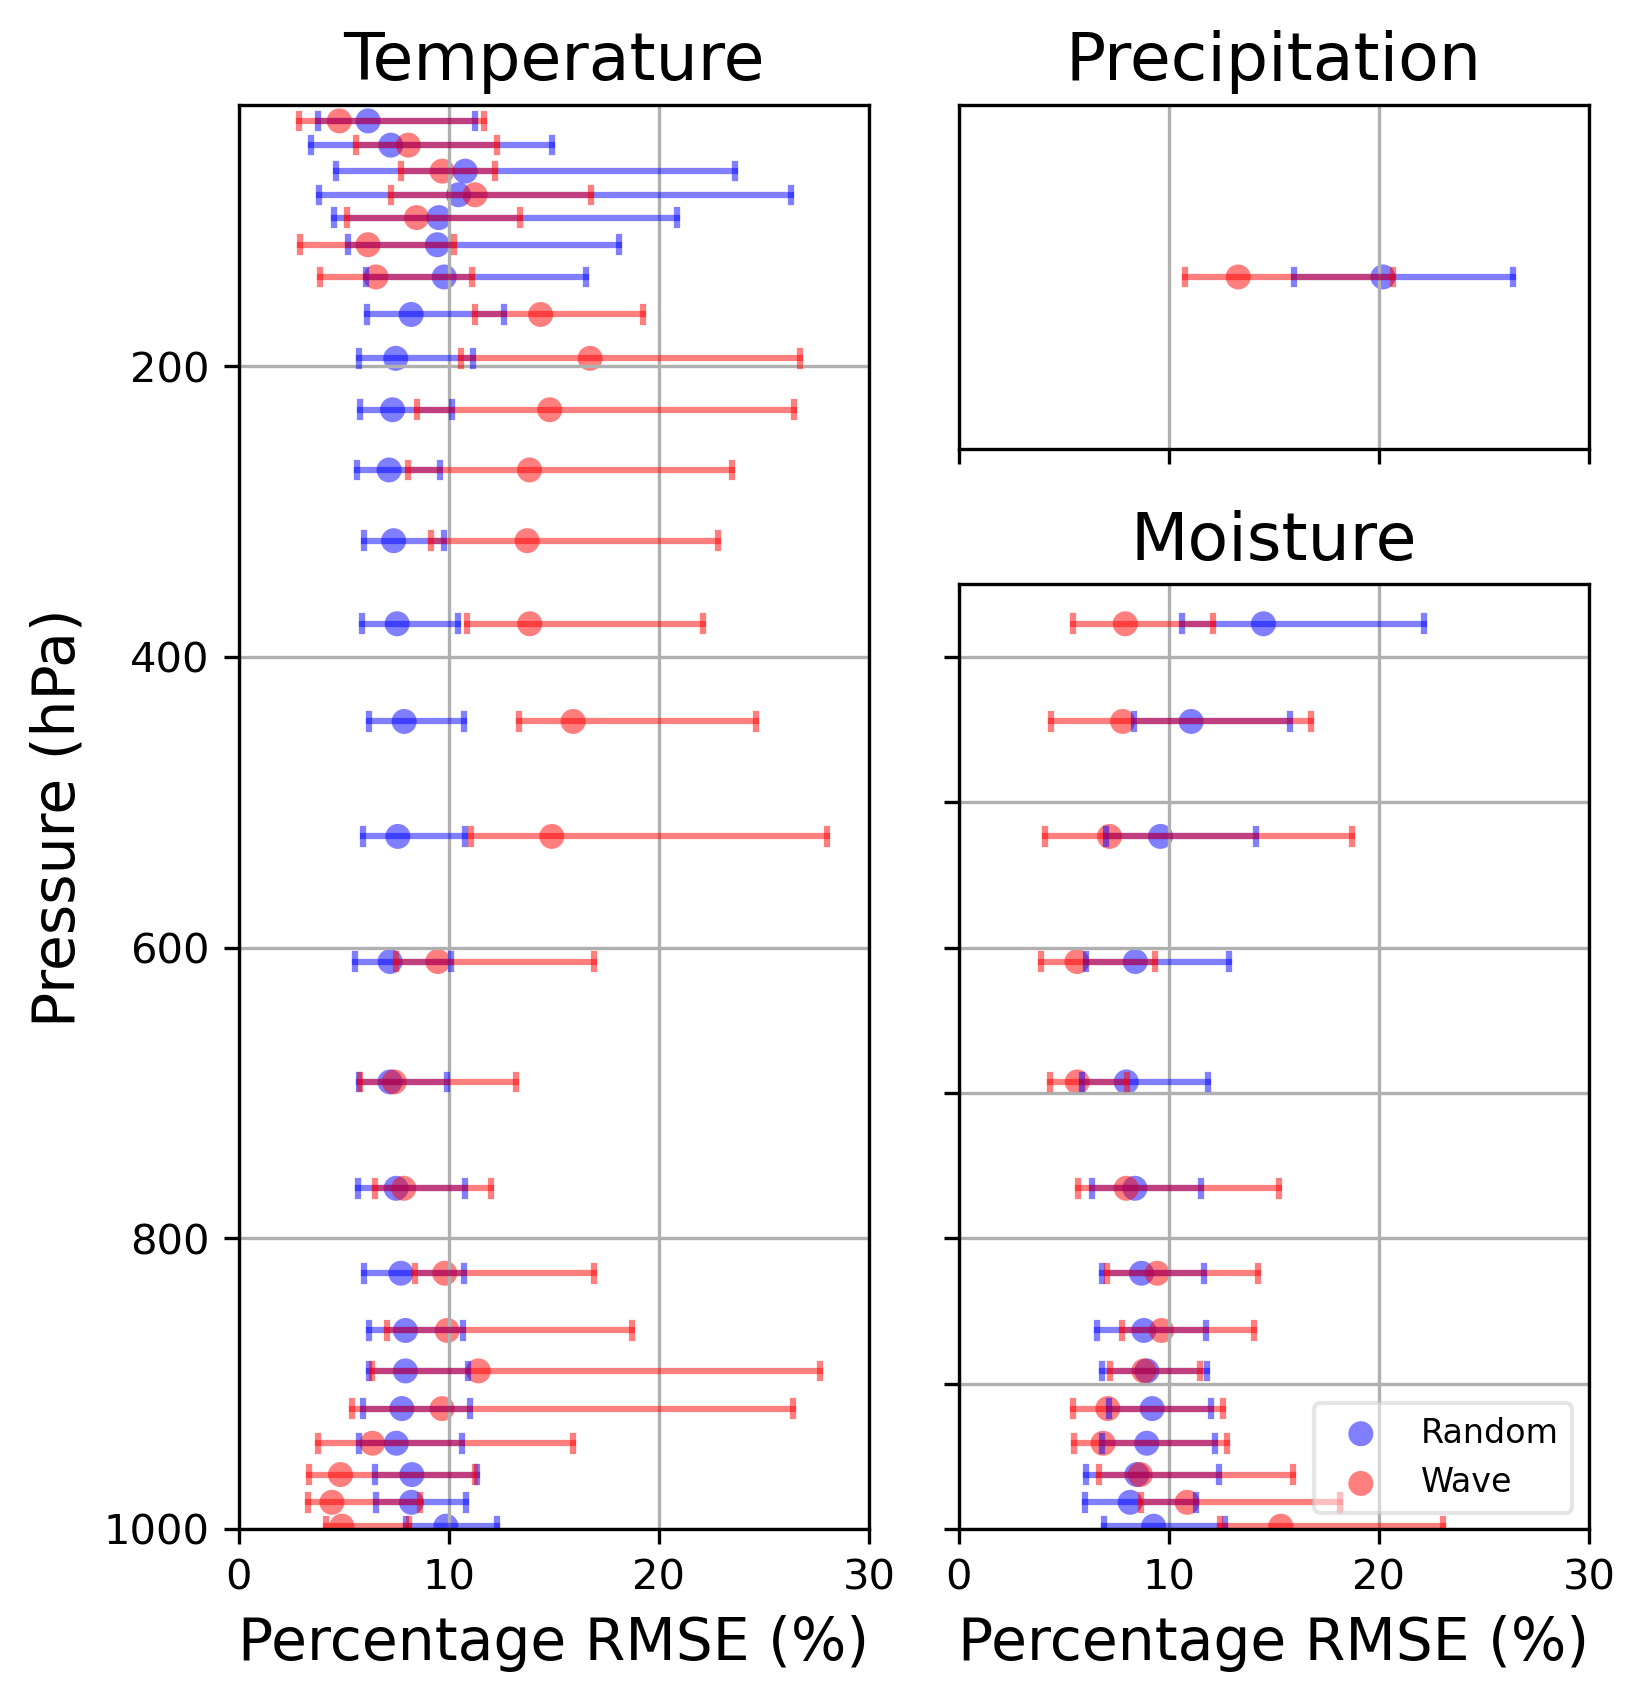

In [12]:
nc_file = '/n/kuangdss01/users/qiyusong/SAM_output/OUT_STAT/RCE_randmultsine_spinup_256_0_3.nc'
data = nc.Dataset(nc_file)
t_wavebg = data.variables['TABS'][:, :].mean(axis=0)
q_wavebg = data.variables['QV'][:, :].mean(axis=0)
p = data.variables['p'][:]
pres = p.squeeze()
fig = plt.figure(figsize=(6, 6), dpi=300)
ax1 = plt.axes([0.125, 0.1, 0.35, 0.98*0.85*0.95])
ax2 = plt.axes([0.525, 0.1, 0.35, 0.65*0.85*0.95])
ax3 = plt.axes([0.525, 0.7, 0.35, 0.1+0.98*0.85*0.95-0.7])
for i in range(26):
    ax1.plot([torch.min(100*rmse_rand[:, i]), torch.max(100*rmse_rand[:, i])], [pres[i], pres[i]], color='b', alpha=0.5)
    ax1.plot([torch.min(100*rmse_rand[:, i]), torch.min(100*rmse_rand[:, i])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    ax1.plot([torch.max(100*rmse_rand[:, i]), torch.max(100*rmse_rand[:, i])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    line1 = ax1.scatter([torch.mean(100*rmse_rand[:, i])], [pres[i]], color='b', alpha=0.5, edgecolor='none')
    ax1.plot([torch.min(100*rmse_wave[:, i]), torch.max(100*rmse_wave[:, i])], [pres[i], pres[i]], color='r', alpha=0.5)
    ax1.plot([torch.min(100*rmse_wave[:, i]), torch.min(100*rmse_wave[:, i])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    ax1.plot([torch.max(100*rmse_wave[:, i]), torch.max(100*rmse_wave[:, i])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    line2 = ax1.scatter([torch.mean(100*rmse_wave[:, i])], [pres[i]], color='r', alpha=0.5, edgecolor='none')
for i in range(14):
    ax2.plot([torch.min(100*rmse_rand[:, i+26]), torch.max(100*rmse_rand[:, i+26])], [pres[i], pres[i]], color='b', alpha=0.5)
    ax2.plot([torch.min(100*rmse_rand[:, i+26]), torch.min(100*rmse_rand[:, i+26])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    ax2.plot([torch.max(100*rmse_rand[:, i+26]), torch.max(100*rmse_rand[:, i+26])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    ax2.scatter([torch.mean(100*rmse_rand[:, i+26])], [pres[i]], color='b', alpha=0.5, edgecolor='none')
    ax2.plot([torch.min(100*rmse_wave[:, i+26]), torch.max(100*rmse_wave[:, i+26])], [pres[i], pres[i]], color='r', alpha=0.5)
    ax2.plot([torch.min(100*rmse_wave[:, i+26]), torch.min(100*rmse_wave[:, i+26])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    ax2.plot([torch.max(100*rmse_wave[:, i+26]), torch.max(100*rmse_wave[:, i+26])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    ax2.scatter([torch.mean(100*rmse_wave[:, i+26])], [pres[i]], color='r', alpha=0.5, edgecolor='none')
ax3.plot([torch.min(100*rmse_rand[:, 40]), torch.max(100*rmse_rand[:, 40])], [141.6, 141.6], color='b', alpha=0.5)
ax3.plot([torch.min(100*rmse_rand[:, 40]), torch.min(100*rmse_rand[:, 40])], [136.6, 146.6], color='b', alpha=0.5)
ax3.plot([torch.max(100*rmse_rand[:, 40]), torch.max(100*rmse_rand[:, 40])], [136.6, 146.6], color='b', alpha=0.5)
ax3.scatter(torch.mean(100*rmse_rand[:, 40]), 141.6, color='b', alpha=0.5, edgecolor='none')
ax3.plot([torch.min(100*rmse_wave[:, 40]), torch.max(100*rmse_wave[:, 40])], [141.6, 141.6], color='r', alpha=0.5)
ax3.plot([torch.min(100*rmse_wave[:, 40]), torch.min(100*rmse_wave[:, 40])], [136.6, 146.6], color='r', alpha=0.5)
ax3.plot([torch.max(100*rmse_wave[:, 40]), torch.max(100*rmse_wave[:, 40])], [136.6, 146.6], color='r', alpha=0.5)
ax3.scatter(torch.mean(100*rmse_wave[:, 40]), 141.6, color='r', alpha=0.5, edgecolor='none')
#ax2.scatter(100*rmse_mean[26:40], pres[:14], color='k', edgecolor='none')
#ax3.scatter(100*rmse_mean[40], 1, color='k', edgecolor='none')
ax2.legend([line1, line2], ['Random', 'Wave'], loc='lower right', fontsize=8, framealpha=0.5)
ax1.set_ylim(1000, 20)
ax2.set_ylim(1000, 350)
ax3.set_ylim(263.2, 20)
ax2.set_yticklabels([])
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax1.set_xlim(0, 30)
ax2.set_xlim(0, 30)
ax3.set_xlim(0, 30)
ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_title('Temperature', fontsize=16)
ax2.set_title('Moisture', fontsize=16)
ax3.set_title('Precipitation', fontsize=16)
ax1.set_ylabel('Pressure (hPa)', fontsize=14)
ax1.set_xlabel('Percentage RMSE (%)', fontsize=14)
ax2.set_xlabel('Percentage RMSE (%)', fontsize=14)
plt.show()

### Percentage Bias

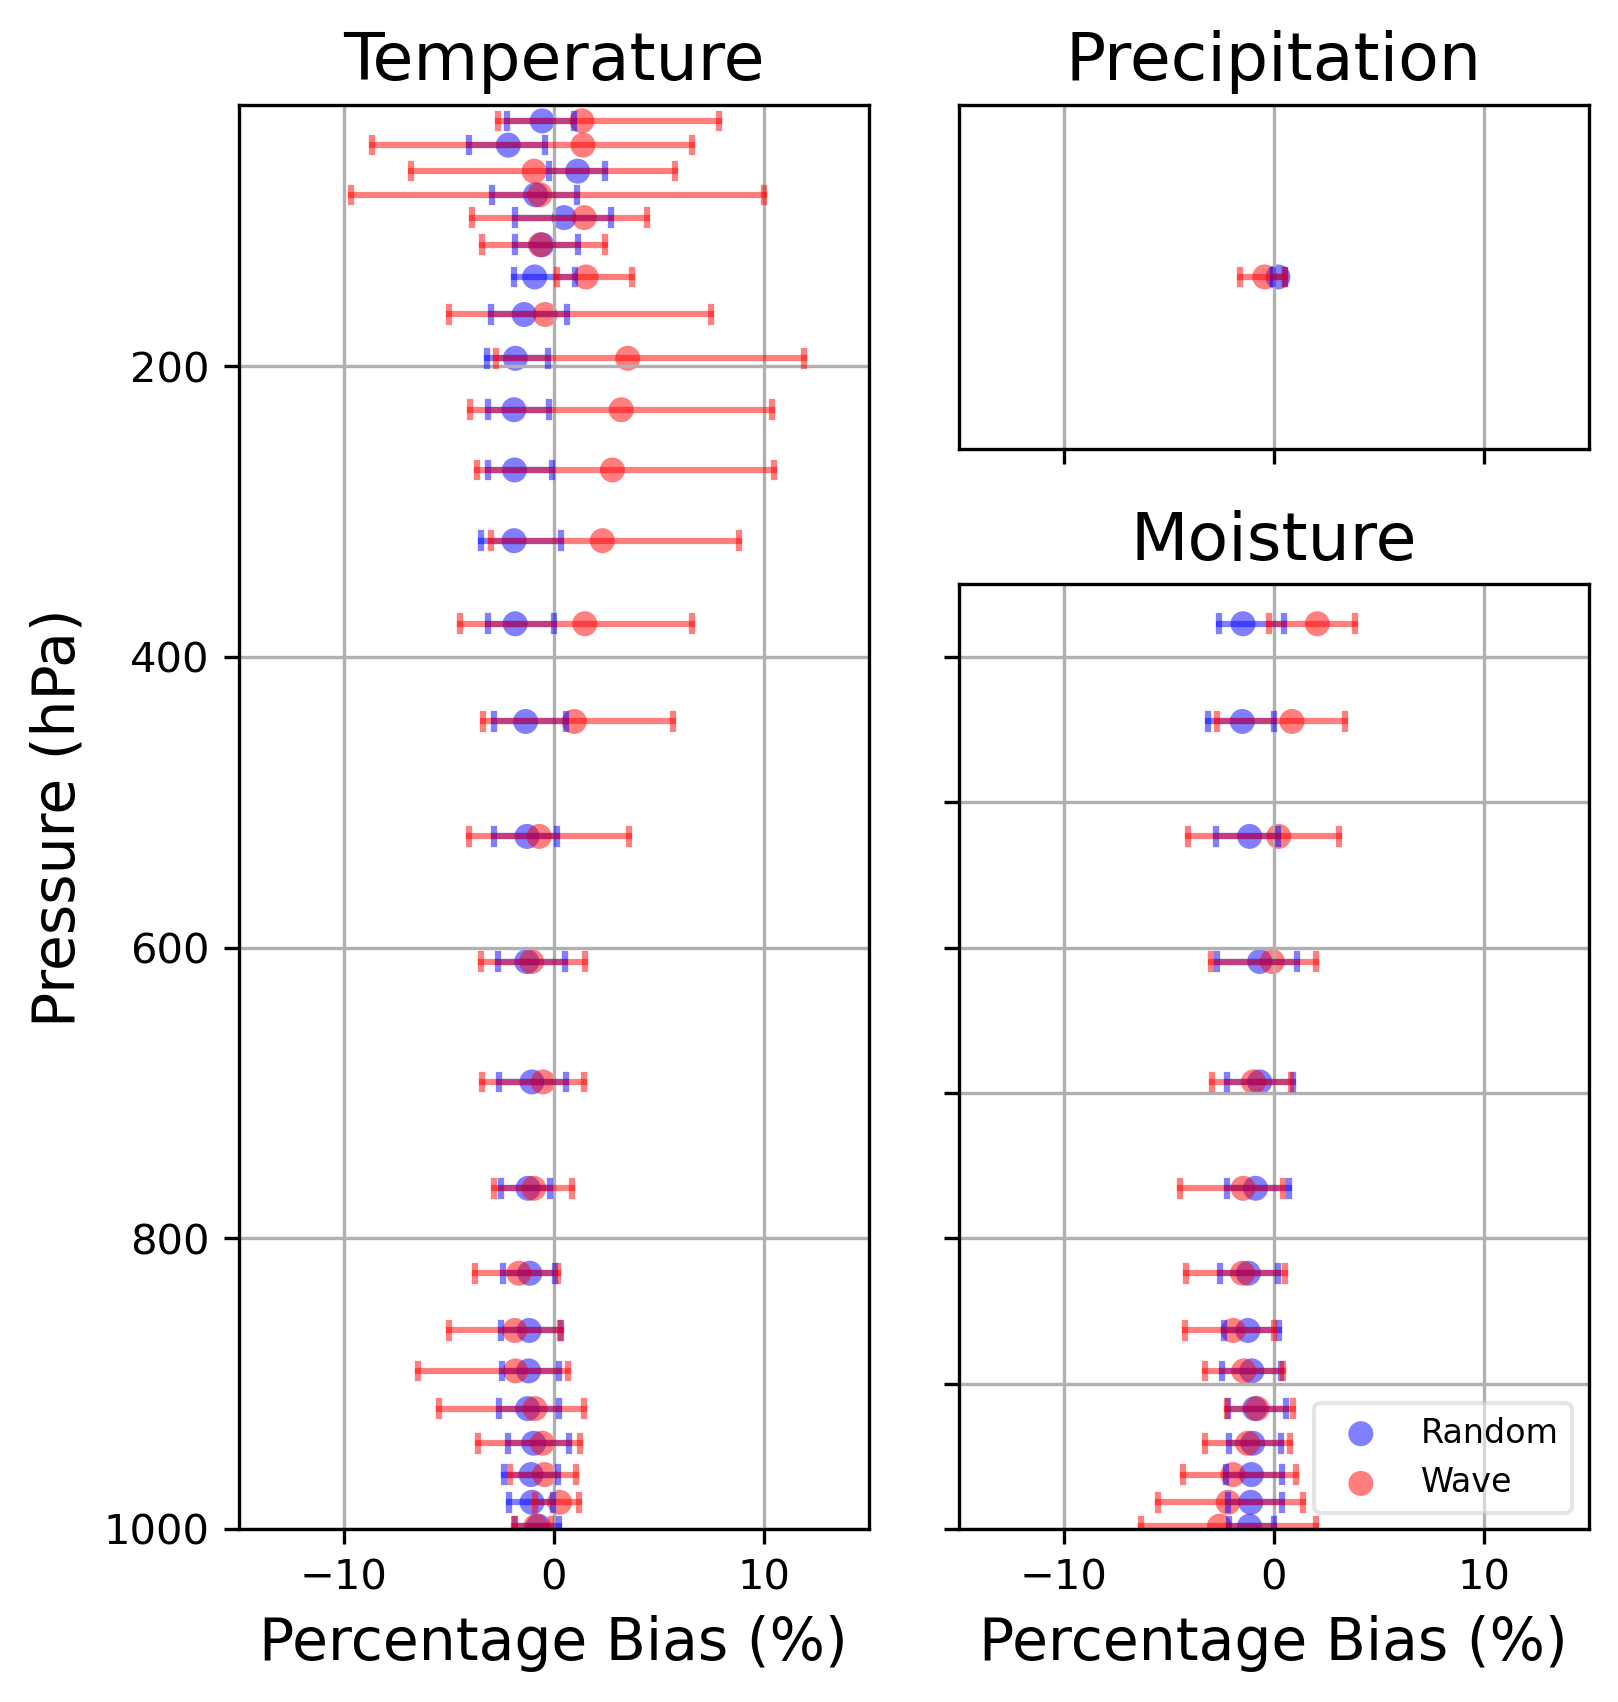

In [15]:
nc_file = '/n/kuangdss01/users/qiyusong/SAM_output/OUT_STAT/RCE_randmultsine_spinup_256_0_3.nc'
data = nc.Dataset(nc_file)
t_wavebg = data.variables['TABS'][:, :].mean(axis=0)
q_wavebg = data.variables['QV'][:, :].mean(axis=0)
p = data.variables['p'][:]
pres = p.squeeze()
fig = plt.figure(figsize=(6, 6), dpi=300)
ax1 = plt.axes([0.125, 0.1, 0.35, 0.98*0.85*0.95])
ax2 = plt.axes([0.525, 0.1, 0.35, 0.65*0.85*0.95])
ax3 = plt.axes([0.525, 0.7, 0.35, 0.1+0.98*0.85*0.95-0.7])
for i in range(26):
    ax1.plot([torch.min(100*bias_rand[:, i]), torch.max(100*bias_rand[:, i])], [pres[i], pres[i]], color='b', alpha=0.5)
    ax1.plot([torch.min(100*bias_rand[:, i]), torch.min(100*bias_rand[:, i])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    ax1.plot([torch.max(100*bias_rand[:, i]), torch.max(100*bias_rand[:, i])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    line1 = ax1.scatter([torch.mean(100*bias_rand[:, i])], [pres[i]], color='b', alpha=0.5, edgecolor='none')
    ax1.plot([torch.min(100*bias_wave[:, i]), torch.max(100*bias_wave[:, i])], [pres[i], pres[i]], color='r', alpha=0.5)
    ax1.plot([torch.min(100*bias_wave[:, i]), torch.min(100*bias_wave[:, i])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    ax1.plot([torch.max(100*bias_wave[:, i]), torch.max(100*bias_wave[:, i])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    line2 = ax1.scatter([torch.mean(100*bias_wave[:, i])], [pres[i]], color='r', alpha=0.5, edgecolor='none')
for i in range(14):
    ax2.plot([torch.min(100*bias_rand[:, i+26]), torch.max(100*bias_rand[:, i+26])], [pres[i], pres[i]], color='b', alpha=0.5)
    ax2.plot([torch.min(100*bias_rand[:, i+26]), torch.min(100*bias_rand[:, i+26])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    ax2.plot([torch.max(100*bias_rand[:, i+26]), torch.max(100*bias_rand[:, i+26])], [pres[i]-5, pres[i]+5], color='b', alpha=0.5)
    ax2.scatter([torch.mean(100*bias_rand[:, i+26])], [pres[i]], color='b', alpha=0.5, edgecolor='none')
    ax2.plot([torch.min(100*bias_wave[:, i+26]), torch.max(100*bias_wave[:, i+26])], [pres[i], pres[i]], color='r', alpha=0.5)
    ax2.plot([torch.min(100*bias_wave[:, i+26]), torch.min(100*bias_wave[:, i+26])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    ax2.plot([torch.max(100*bias_wave[:, i+26]), torch.max(100*bias_wave[:, i+26])], [pres[i]-5, pres[i]+5], color='r', alpha=0.5)
    ax2.scatter([torch.mean(100*bias_wave[:, i+26])], [pres[i]], color='r', alpha=0.5, edgecolor='none')
ax3.plot([torch.min(100*bias_rand[:, 40]), torch.max(100*bias_rand[:, 40])], [141.6, 141.6], color='b', alpha=0.5)
ax3.plot([torch.min(100*bias_rand[:, 40]), torch.min(100*bias_rand[:, 40])], [136.6, 146.6], color='b', alpha=0.5)
ax3.plot([torch.max(100*bias_rand[:, 40]), torch.max(100*bias_rand[:, 40])], [136.6, 146.6], color='b', alpha=0.5)
ax3.scatter(torch.mean(100*bias_rand[:, 40]), 141.6, color='b', alpha=0.5, edgecolor='none')
ax3.plot([torch.min(100*bias_wave[:, 40]), torch.max(100*bias_wave[:, 40])], [141.6, 141.6], color='r', alpha=0.5)
ax3.plot([torch.min(100*bias_wave[:, 40]), torch.min(100*bias_wave[:, 40])], [136.6, 146.6], color='r', alpha=0.5)
ax3.plot([torch.max(100*bias_wave[:, 40]), torch.max(100*bias_wave[:, 40])], [136.6, 146.6], color='r', alpha=0.5)
ax3.scatter(torch.mean(100*bias_wave[:, 40]), 141.6, color='r', alpha=0.5, edgecolor='none')
#line3 = ax1.scatter(100*bias_mean[:26], pres[:26], color='k', edgecolor='none')
#ax2.scatter(100*bias_mean[26:40], pres[:14], color='k', edgecolor='none')
#ax3.scatter(100*bias_mean[40], 1, color='k', edgecolor='none')
ax2.legend([line1, line2], ['Random', 'Wave'], loc='lower right', fontsize=8, framealpha=0.5)
ax1.set_ylim(1000, 20)
ax2.set_ylim(1000, 350)
ax3.set_ylim(263.2, 20)
ax2.set_yticklabels([])
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax1.set_xlim(-15, 15)
ax2.set_xlim(-15, 15)
ax3.set_xlim(-15, 15)
ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_title('Temperature', fontsize=16)
ax2.set_title('Moisture', fontsize=16)
ax3.set_title('Precipitation', fontsize=16)
ax1.set_ylabel('Pressure (hPa)', fontsize=14)
ax1.set_xlabel('Percentage Bias (%)', fontsize=14)
ax2.set_xlabel('Percentage Bias (%)', fontsize=14)
plt.show()